# 1. Problem Definition

### Goal
Our primary objective is to develop an image-based classifier to distinguish between three specific states of human activity:
* **Fainted**
* **Sleeping**
* **Awake**

### Motivation
This project is designed to support the continuous monitoring of individuals requiring medical supervision, such as the elderly or patients at risk of sudden loss of consciousness.

By automatically detecting potentially dangerous states like **fainting**, the system aims to:
* Enable faster response times.
* Reduce the reliance on constant human observation.

### Expected Challenges
Developing a robust classifier for this task involves overcoming several inherent difficulties:
1.  **Visual Similarity:** Distinguishing between *sleeping* and *fainted* states is visually subtle and difficult.
2.  **Environmental Variance:** Variations in lighting conditions, camera angles, and image resolution significantly impact model performance.
3.  **Subject Variability:** Differences in body posture, clothing, and physical appearance introduce substantial noise.
4.  **Data Imbalance:** Limited availability of specific "fainting" data can bias the classifier toward more common classes.
5.  **Lack of Temporal Context:** Classifying single static images lacks the motion cues that often help distinguish a faint from simply lying down.

---

# 2. Dataset Creation & Preparation

### Data Sourcing
We initiated a search for relevant training data on platforms like **Kaggle** and **Roboflow**. While datasets with similar classes existed (e.g., Fall Detection, Sleep Pose), none perfectly matched our specific objective. We aggregated a sufficient number of images from these related sources to form our base dataset.

**Sources:**
* [People Sleeping Dataset](https://images.cv/download/people_sleeping/318)
* [Fall Detection Dataset (Kaggle)](https://www.kaggle.com/datasets/uttejkumarkandagatla/fall-detection-dataset?resource=download)

### Data Curation
To ensure high model precision, we performed rigorous manual filtering to remove "noisy" data.
* **Refinement Strategy:** We specifically targeted ambiguous images that could confuse the model.
* **Examples of Excluded Data:**
    * Images from fainting datasets where subjects had their eyes open.
    * "Fainting" subjects with feet off the ground (indicating a jump or fall rather than a static fainted state).

### Dataset Structure
The final dataset is organized into a standard train/test split directory structure:

```text
├───test
│   ├───awake
│   ├───fainted
│   └───sleeping
└───train
    ├───awake
    ├───fainted
    └───sleeping

In [95]:
from fastai.vision.all import *

train_path = Path("data/train")
test_path = Path('data/test')

# 3. Data Loading


In [96]:
failed = verify_images(get_image_files(train_path))
failed.map(Path.unlink)
if failed:
    print(f"The number of the images that that invalid: {len(failed)}")
else:
    print("All images are valid.")

All images are valid.


In [97]:
dls = DataBlock(
    blocks=[ImageBlock, CategoryBlock],
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(224)
).dataloaders(train_path)

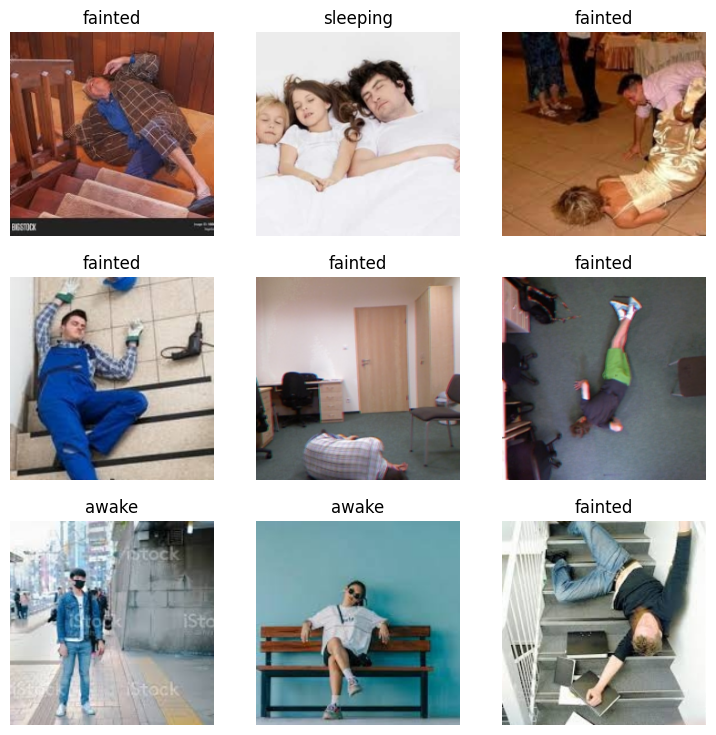

In [98]:
dls.show_batch(max_n=9)

# 4. Model Training

In [99]:
epochs = 3 # more than 3 epochs caused overfitting
learn = vision_learner(dls, resnet34,
                       metrics=[error_rate, accuracy, Precision(average='macro'), Recall(average='macro')])

learn.fine_tune(epochs)

epoch,train_loss,valid_loss,error_rate,accuracy,precision_score,recall_score,time
0,1.447253,0.691999,0.223404,0.776596,0.764430,0.806897,00:02


epoch,train_loss,valid_loss,error_rate,accuracy,precision_score,recall_score,time
0,0.438537,0.263356,0.106383,0.893617,0.869577,0.913426,00:03
1,0.320958,0.164908,0.053191,0.946809,0.931495,0.955834,00:03
2,0.240951,0.162651,0.042553,0.957447,0.947459,0.963964,00:03


# 5. Evaluation

<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

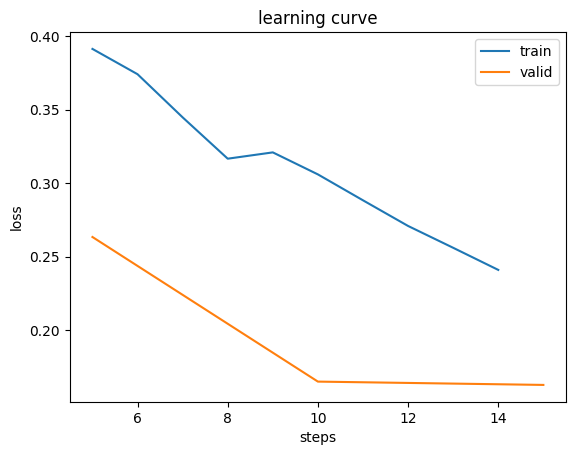

In [100]:
learn.recorder.plot_loss()

Plotting these metrics: ['error_rate', 'accuracy', 'precision_score', 'recall_score', 'time']


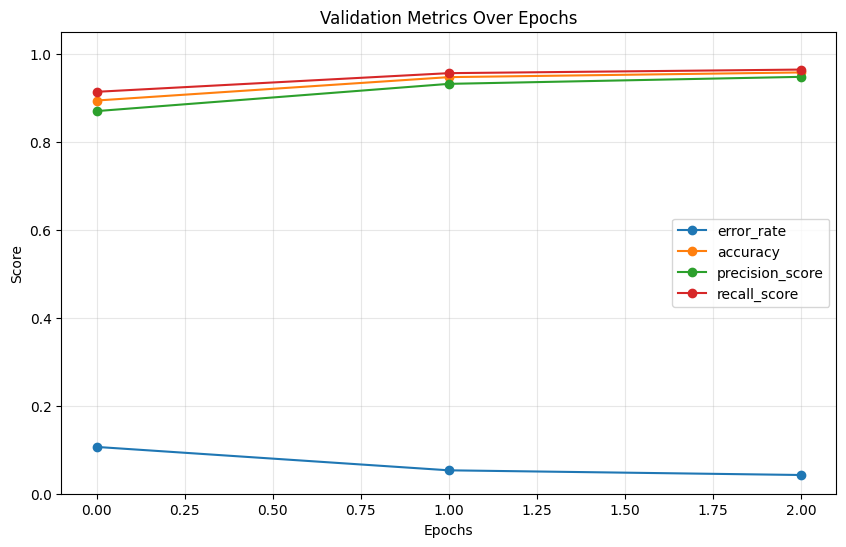

In [101]:
# grab the names of the metrics
metric_names = learn.recorder.metric_names[3:]
print(f"Plotting these metrics: {metric_names}")

# grab the actual numbers
values = list(zip(*learn.recorder.values))

# create the Plot
plt.figure(figsize=(10, 6))

for i, name in enumerate(metric_names):
    # We start fetching values from index 2 because indices 0 & 1 are losses
    if i + 2 < len(values):
        plt.plot(values[i+2], label=name, marker='o')

plt.title('Validation Metrics Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, 1.05) # force y-axis to show 0% to 100%
plt.show()

In [102]:
test_files = get_image_files(test_path)
test_dl = learn.dls.test_dl(test_files, with_labels=True)
results = learn.validate(dl=test_dl)

print(f"Validation Loss: {results[0]:.4f}")
print(f"Error Rate:      {results[1]:.2%}")
print(f"Accuracy:        {results[2]:.2%}")
print(f"Precision:       {results[3]:.2%}")
print(f"Recall:          {results[4]:.2%}")


Validation Loss: 0.3329
Error Rate:      9.52%
Accuracy:        90.48%
Precision:       91.02%
Recall:          90.48%


### 5.1 Confusion Matrix

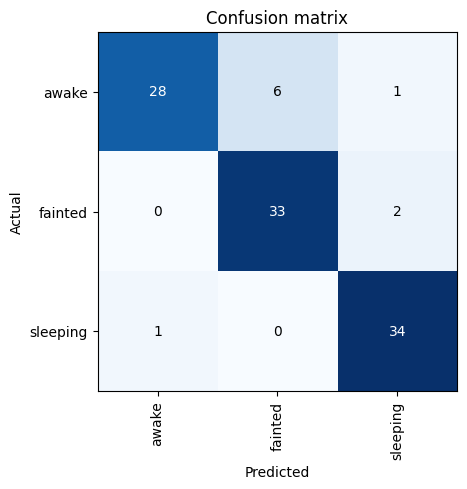

In [103]:
interp = ClassificationInterpretation.from_learner(learn, dl=test_dl)
interp.plot_confusion_matrix()

### 5.2 Examples of predictions
* Incorrect Predictions:

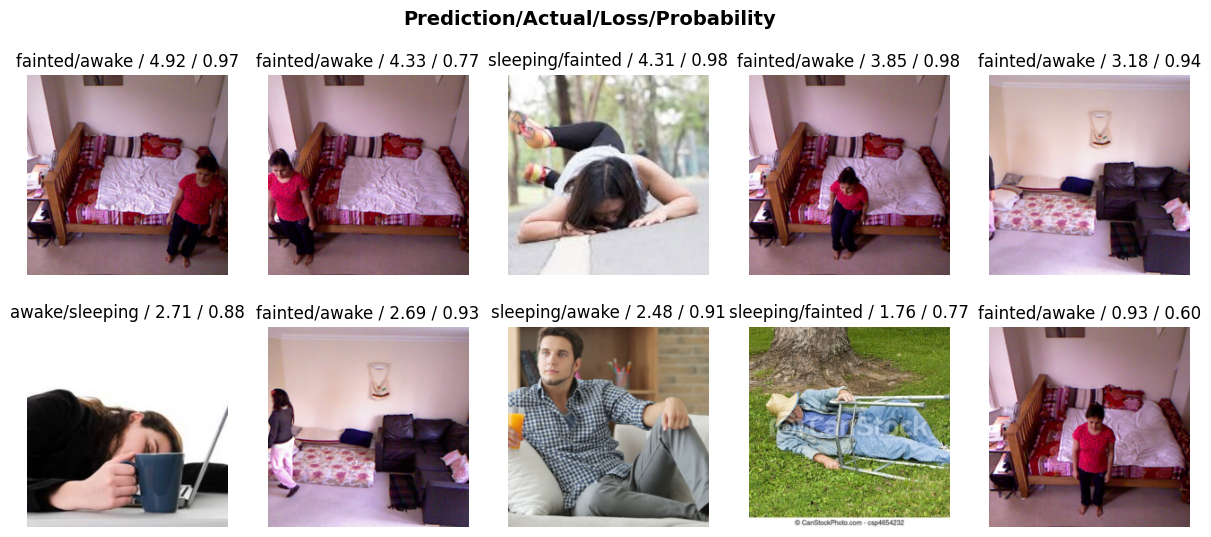

In [104]:
interp.plot_top_losses(10, nrows=2)

* Correct Predictions:

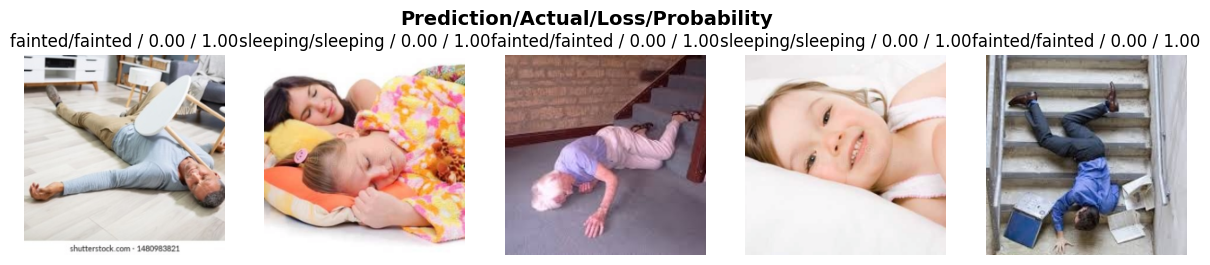

In [105]:
# largest=False asks for the SMALLEST loss (Best predictions)
interp.plot_top_losses(5, nrows=1, largest=False)

### 5.3 Discussion and future steps
*Based on the metrics and visualizations above, we observe the following:*

**Strengths:**

*Based on the confusion matrix and lowest-loss predictions, the model demonstrates the following robust capabilities:*

* **Exceptional "Sleeping" Precision:** The model exhibits its strongest performance on the 'Sleeping' class (34/35 correct). Crucially, there are **zero instances** of 'Sleeping' subjects being misclassified as 'Fainted'. This confirms the model has successfully learned distinct physiological features (e.g., closed eyes, peaceful expression, presence of bedding) rather than relying solely on horizontal posture.
* **High Confidence on Archetypes:** The "Best Predictions" visualization reveals that for clear, unambiguous examples, the model achieves near-perfect confidence (Probability: 1.00, Loss: ~0.00). It flawlessly identifies:
    * **Awake:** Subjects standing upright or sitting attentively (e.g., man on sofa).
    * **Fainted:** Subjects in unnatural, crumpled postures on hard surfaces (stairs, tiled floors).
    * **Sleeping:** Subjects in typical resting positions with clear context (beds, pillows).
* **Environmental & Demographic Robustness:** The model correctly classifies subjects across a wide variety of environments (staircases, living rooms, outdoors, bedrooms) and demographics (children, elderly, adults). This suggests the model is generalizing well to different visual contexts and is not overfitting to a specific background type (e.g., it does not assume "bedroom = sleeping" exclusively, as it correctly identifies fainted subjects in domestic settings).
* **differentiation of "Resting" vs. "Collapsed":** Despite the visual similarity between fainting and sleeping, the confusion matrix shows very low crosstalk between these two specific classes. The model effectively separates "intentional rest" (sleeping) from "unintentional collapse" (fainting), likely leveraging cues like limb positioning and muscle tension.

**Weaknesses:**

*Based on the top losses and error analysis, we observed the following critical weaknesses:*

* **Severe "Surveillance View" Bias:** The most significant errors reveal that the model has overfit to the **camera perspective** rather than the subject's state. It confidently misclassifies **standing, walking subjects** as 'Fainted' simply because the image is taken from a high-angle, wide-angle (CCTV-style) view. The model has incorrectly learned that "looking down at a room" implies a fainting event, disregarding the fact that the subject is upright.
* **Context Over-Reliance (The "Sofa" Problem):** The model struggles to distinguish "Relaxing" from "Sleeping." In instances where "Awake" subjects are sitting comfortably, the model predicts 'Sleeping'. This suggests it relies too heavily on environmental cues (presence of beds/sofas) rather than the subject's actual alertness (e.g., eyes open, holding a drink).
* **Vertical Sleeping Ambiguity:** Conversely, the model fails to identify 'Sleeping' subjects if they are not lying horizontally. For example, subjects sleeping with their heads on a desk (vertical torso, loss #2) are misclassified as 'Awake'. The model appears to use "verticality" as a hard rule for the 'Awake' class, failing to account for napping in seated positions.

**Future Improvements:**

*Based on the analysis above, we propose the following steps to enhance model robustness:*

* **Mitigate Perspective Bias:** To fix the "Surveillance View" error (where high angles are incorrectly flagged as fainting), we must break the correlation between camera angle and class. We will add a specific dataset of **"Awake" subjects filmed from high/CCTV angles** (walking, standing) to teach the model that camera perspective does not dictate the label.
* **Advanced Data Augmentation:** We will implement **Perspective Warping** during training. By artificially distorting standard "Awake" images to simulate high-angle or tilted views, we can force the model to focus on the subject's body features rather than the camera's viewpoint.
* **Contextual Regularization:** To prevent the model from assuming "Sofa = Sleeping," we can introduce **Random Erasing** augmentation. This randomly obscures parts of the image (including background furniture), forcing the classifier to look for the person's actual state (e.g., open eyes) rather than environmental context cues.
* **Test Time Augmentation (TTA):** As an immediate step for inference, we will implement TTA. By averaging predictions across multiple crops and flips, we can resolve edge cases where a specific static angle confused the model (e.g., clarifying the "Vertical Sleeping" ambiguity by offering different views of the same subject).